# `ABaCo` demo: Mgnify study `MGYS00001135`

In this demo we will implement ABaCo for batch correction on Mgnify study [MGYS00001135](https://www.ebi.ac.uk/metagenomics/studies/MGYS00001135#overview) and ENA Bioproject [PRJEB13832](https://www.ebi.ac.uk/ena/browser/view/PRJEB13832), a proof-of-concept study for surveilling infections diseases and AMR via metagenomics analysis of local sewage samples in Copenhagen.

-----
**Data Description:**
- The metagenomics dataset collected by the Technical University of Denmark (DTU) and analysed via Mgnify [pipeline version 2.0](https://www.ebi.ac.uk/metagenomics/pipelines/2.0) is a dataset composed of 54 samples with 749 identified taxa at the genus level. 
- The samples were collected from 3 different wastewater treatment plant (WWTP) locations, accounting for the biological source of variation. 
- Samples were analyzed on 2 different dates accounting for the technical source of variation (i.e., batch effect).
- The sample data and metadata were retrieved from the [Mgnify API](https://docs.mgnify.org/src/docs/api.html) using the following [mgnifyapi repo](https://github.com/Multiomics-Analytics-Group/Retrieve_info_MGnifyAPI/tree/angel-learning) and stored as an Annotated Dataset [AnnData](https://anndata.readthedocs.io/en/latest/index.html). 

**Goal:**

With ABaCo the aim is to remove the technical variation (batch effect) while maintaining any biological variation (wastewater treatment plant location). 

-----

To start we read in the annotated dataset. 

In [1]:
import anndata as ad
import pandas as pd 
import numpy as np

# read in annotated dataset
adata = ad.read_h5ad("data/mgnify_MGYS00001135.h5ad")
# print details
adata

AnnData object with n_obs × n_vars = 54 × 749
    obs: 'analysis_id', 'sample_id', 'assembly_run_id', 'experiment_type', 'pipeline_version', 'study_id', 'instrument_platform', 'sample_name', 'biosample', 'sample_description', 'latitude', 'longitude', 'geolocation', 'biome_feature', 'biome_material', 'id', 'collection_date', 'collection_date_year', 'collection_date_month', 'collection_date_day', 'analysis_completed_date', 'analysis_completed_date_year', 'analysis_completed_date_month', 'analysis_completed_date_day', 'fname_run_id', 'erp_id', 'study_name', 'n_samples', 'biomes', 'ww_plant', 'X_numtaxa', 'X_chao1', 'X_shannon', 'X_pielou', 'X_simpson', 'X_inv_simpson'
    var: 'sk', 'k', 'p', 'c', 'o', 'f', 'g'
    layers: 'abaco', 'clr_X', 'clr_abaco', 'normalized_X', 'normalized_abaco'

The columns (variables, vars) are the different taxa annotated with taxonomic ranks (sk = super kingdom, k = kingdom, p = phylum, c = class, o = order, f = family, g = genus).

The rows (observations, obs) are the metadata for the different samples in the study MGYS00001135. 

The ones of interest for this demo are: 
- The `analysis_completed_date` which accounts for batch effect for our purposes, and
- `ww_plant` which are the different sampling locations and we will use as our biological variance that we wish to retain after batch correction.

-----

We can easily extract a df from anndata so that we meet the data format required for abaco.

In [2]:
batch_col = 'analysis_completed_date'
bio_col = 'ww_plant'
id_col = 'index'

# the raw counts as df
df_taxa = adata.to_df()

# appending on the categorical data of interest
df_all = pd.concat([df_taxa, adata.obs[[batch_col, bio_col]]], axis=1).reset_index()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Columns: 752 entries, index to ww_plant
dtypes: category(2), float64(749), object(1)
memory usage: 316.9+ KB


**`pd.DataFrame` Requirements for ABaCo:**

The dataset contains the following making it compatible with the ABaCo framework:

| id_col | batch_col  | bio_col  | count1 | count2 | ... |
|--------|------------|----------|--------|--------|-----|
| A      | 24/07/2025 | RA       | #      | #      | ... |
| B      | 15/06/2024 | RD       | #      | #      | ... |
| C      | 24/07/2025 | RL       | #      | #      | ... |

- The data has categorical columns: 
    1. unique ids to identify the observations/samples e.g. sample id col
    2. ids for the batch/factor groupings to be corrected by abaco. e.g. dates of sample analysis batch_col
    3. biological/experimental factor variation for abaco to retain when correcting batch effect e.g., sampling location bio_col

- And taxa counts to be trained on. 

We can use `abaco.BatchEffectPlots.plotPCoA()` to visualize any batch and biological effects based on the given categories. 

In [ ]:
from abaco.BatchEffectPlots import plotPCoA
import plotly.io as pio
pio.renderers.default = "notebook_connected"

plotPCoA(
    data=df_all, 
    sample_label=id_col, 
    batch_label=batch_col,  
    experiment_label=bio_col,
)

>> clustergrammer2 backend version 0.18.0


- Batch effect (colours): 
    - Analysis of the samples were completed on 2 different dates which could result in a technical source of variation captured by the slight clustering of batches along PCo1
- Biological effect (shapes): 
    - The samples were collected from 3 different wwtps which we use as the biological source of variation for abaco to retain during batch correction. 
    - There isn't a clear clustering of shapes in the PCoA plot, but we can take a look at other metrics such as alpha diversity indices between wwtp locations that should be retained after abaco reconstruction.

## Alpha diversity of original samples

For each sample we will calculate the below richess, evenness and diversity indices and store them as additional sample (obs) metadata in the anndata set.

Richness
- number of unique species per sample
- Chao1 estimate - correction to above which is likely an underestimation

Diversity
- Shannon diversity index - if a sample is more diverse then there is more entropy (predicting the next taxa is more difficult) and thus the Shannon diversity index is higher. 
- Simpson index (and inverse) - probability of 2 microbes being the same taxa (Simpson index closer to 0 is more diverse, while a higher inverse Simpson index means a sample is more diverse)

Evenness
- Pielou's evenness index - when abundances are more homogenous in a sample then more even so higher Pielou

The formulas are included with the below code. The metrics name will be prefixed with 'X_' so that we can later compare them to 'abaco_' metrics. 

### Preprocessing the count tables

The raw counts require preprocessing because samples will have different total read counts due to technical differences during sequencing. We can normalize the samples to get relative abundances of the taxa summing to 1 (composition data).

In [4]:
# normalize original data and store as additional anndata layer
adata.layers['normalized_X'] = (adata.X/adata.X.sum(axis=1).reshape(-1,1))
# sanity check 
adata.layers['normalized_X'].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

Our normalized, compositional data (CoDa) is bound to a simplex. To move forward with any statistical tests or ML we can choose to map the coda to unconstrained vectors by log-ratio transforming (e.g., centred log-ratio via `skbio.stats.composition.clr()`) the data. 

In [5]:
from skbio.stats.composition import clr 

# CLR transform normalized data, replacing zeros with smallll val to avoid log(0)
adata.layers['clr_X'] = clr(np.where(adata.layers['normalized_X'] > 0, adata.layers['normalized_X'], 1e-10))

# save anndata with new layers
adata.write_h5ad("data/mgnify_MGYS00001135.h5ad")

### Alpha diversity as sample metadata

In [6]:
# Diversity: Number of unique taxa per sample as new metadata
adata.obs['X_numtaxa'] = (adata.X > 0).sum(axis=1) 

# Diversity with correction: Chao1 estimator
# Chao1 = num observed taxa + (num singletons / (2 x num doubletons))
num_singletons = (adata.X == 1).sum(axis=1)
num_doubletons = (adata.X == 2).sum(axis=1)
adata.obs['X_chao1'] = (adata.X > 0).sum(axis=1) + (num_singletons / (2 * num_doubletons))

# Diversity: Shannon index H = -sum(p_i * log(p_i)), entropy
from scipy.stats import entropy
adata.obs['X_shannon'] = entropy(adata.layers['normalized_X'], nan_policy='omit', axis=1)

# Evenness: Pielou evenness index P = H/H_max, H_max = ln(num species)
adata.obs['X_pielou'] = adata.obs['X_shannon'] / np.log(adata.obs['X_numtaxa'])

# Diversity: simpson index lambda = sum(p_i ^2)
adata.obs['X_simpson'] = (adata.layers['normalized_X'] ** 2).sum(axis=1)

# Diversity: inverse simpson index D = 1/lambda
adata.obs['X_inv_simpson'] = 1 / adata.obs['X_simpson']

We can quickly visualize the distribution and relationships between the metrics by batch and biological groups using [`seaborn.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

[None]

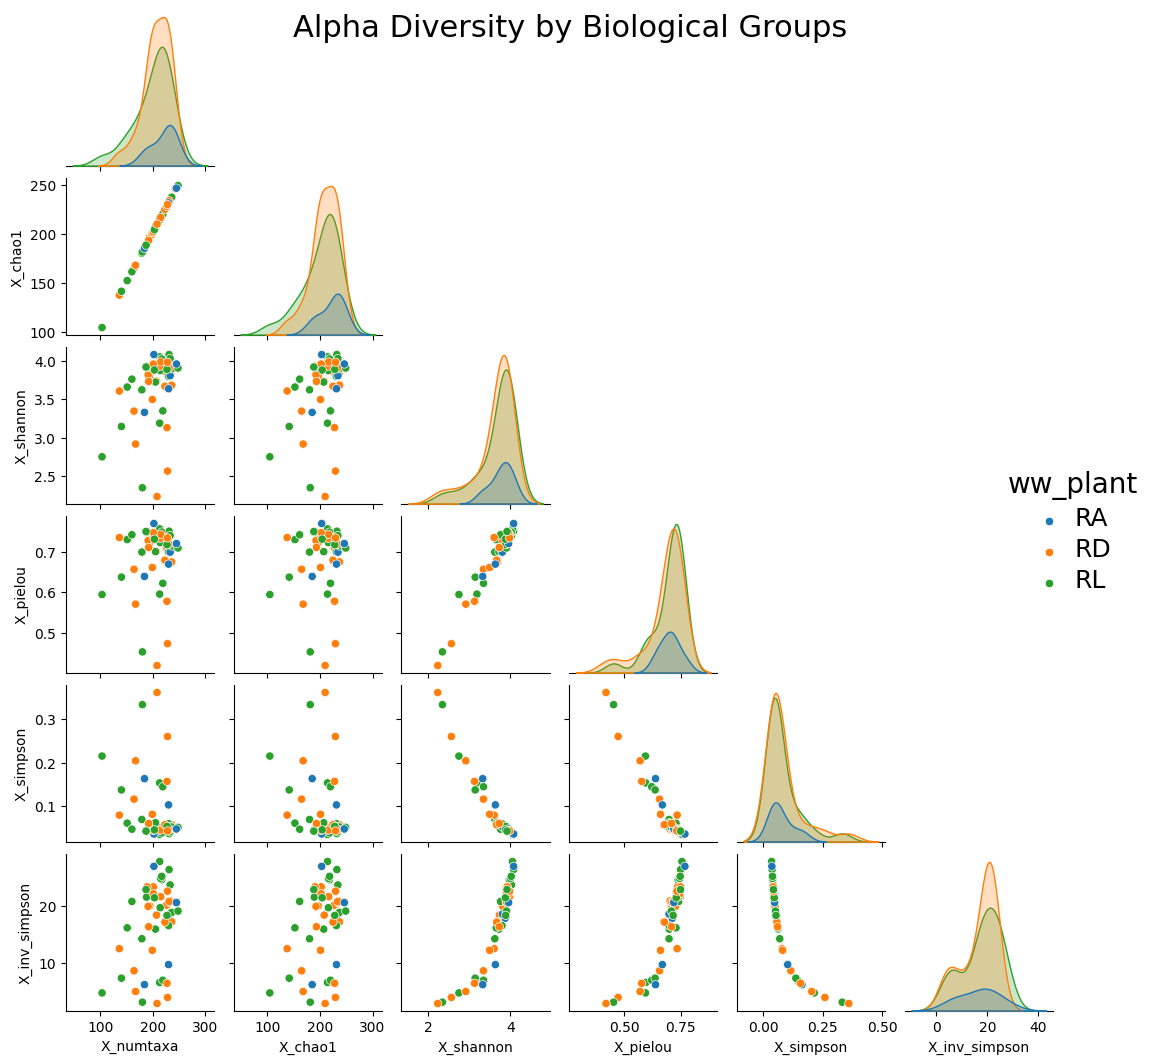

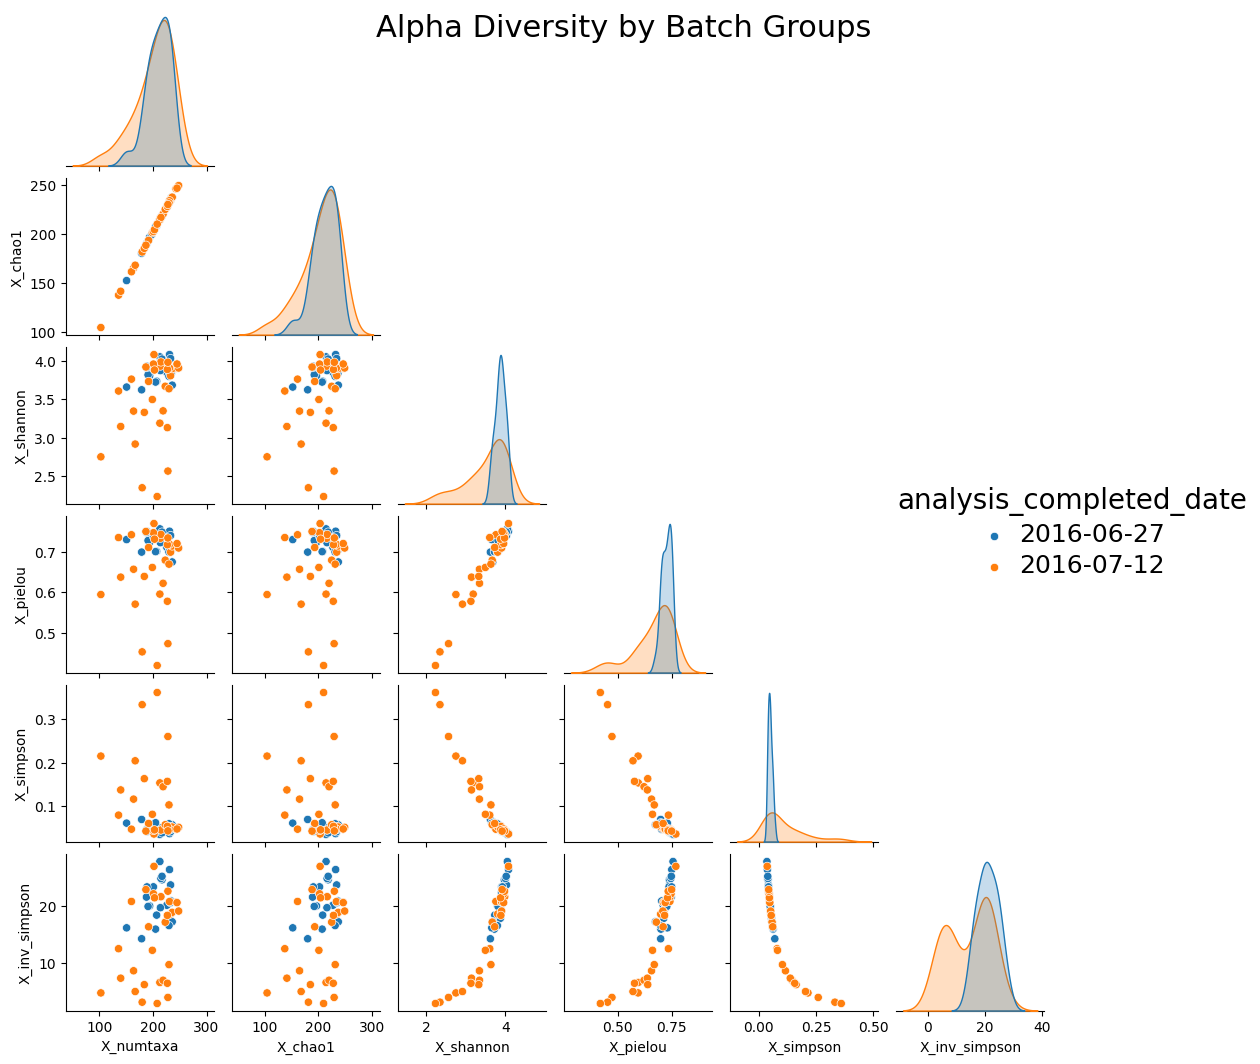

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# preparing the df for vis
df_alphas = adata.obs[[
    'X_numtaxa', 'X_chao1', 'X_shannon', 
    'X_pielou', 'X_simpson', 'X_inv_simpson',
    batch_col, bio_col
]].copy()

# plotting by bio groups
g1 = sns.pairplot(df_alphas, hue=bio_col, corner=True, height=1.8)
g1.figure.suptitle('Alpha Diversity by Biological Groups', fontsize=22)
plt.setp(g1._legend.get_texts(), fontsize=18)
plt.setp(g1._legend.get_title(), fontsize=20)

g2 = sns.pairplot(df_alphas, hue=batch_col, corner=True, height=1.8)
g2.figure.suptitle('Alpha Diversity by Batch Groups', fontsize=22)
plt.setp(g2._legend.get_texts(), fontsize=18)
plt.setp(g2._legend.get_title(), fontsize=20)

The pairplots suggest that the batch effect could be influencing the alpha diversity of the samples. 

-----



## The goal 

Here the aim of **ABaCo** is to: 
1) correct the batch effect (e.g., the points should no longer cluster by colour in the PCoA and pairplot) while
2) maintaining biological variance (e.g., the pairplot coloured by bio group should be not change).

Ideally, after using AbaCo to transform the data, the resulting PCoA and pairplot coloured by batches will look like a colourful mixture of points and the pairplot coloured by wwtp location should not change.

-----

## Using `ABaCo`

### Setting up ABaCo

We instantiate the `abaco.metaABaCo()` class and pass the required parameters shown in the cell below. Thus, running abaco with the default optional parameters.

Usually, setup of the parameters is required, which are explained in brief in the documentation e.g. `help(metaABaCo)`

In [8]:
from abaco.ABaCo import metaABaCo
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instaantiate the ABaCo model
model = metaABaCo(
    data=df_all, # Pre-processed dataframe
    n_bios=df_all[bio_col].nunique(), # Number of biological groups in the data
    bio_label=bio_col, # Column where biological groups are labeled in the dataframe
    n_batches=df_all[batch_col].nunique(), # Number of batch groups in the data
    batch_label=batch_col, # Column where batch groups are labeled in the dataframe
    n_features=df_taxa.shape[1], # Number of features (taxonomic groups)
    prior="MoG", # Prior distribution 
    device=device, # Device
)

In [9]:
help(metaABaCo)

Help on class metaABaCo in module abaco.ABaCo:

class metaABaCo(torch.nn.modules.module.Module)
 |  metaABaCo(data, n_bios, bio_label, n_batches, batch_label, n_features, device, prior='MoG', pdist='ZINB', d_z=16, epochs=[1000, 2000, 2000], encoder_net=[512, 256, 128], decoder_net=[128, 256, 512], vae_act_fun=ReLU(), disc_net=[128, 64], disc_act_fun=ReLU())
 |  
 |  Method resolution order:
 |      metaABaCo
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, n_bios, bio_label, n_batches, batch_label, n_features, device, prior='MoG', pdist='ZINB', d_z=16, epochs=[1000, 2000, 2000], encoder_net=[512, 256, 128], decoder_net=[128, 256, 512], vae_act_fun=ReLU(), disc_net=[128, 64], disc_act_fun=ReLU())
 |      Function to create the metaABaCo model.
 |      
 |      Parameters
 |      ----------
 |      data: pd.DataFrame
 |          Pre-processed DataFrame to correct. Only feature columns to correct should be of numer

### Training the ABaCo model

To train ABaCo on the prepared dataset, we then use method `abaco.metaABaCo.correct()`. 

In [10]:
# Train the model
model.correct(seed=42)

Training: VAE for learning meaningful embeddings: 100%|██████████| 1000/1000 [00:21<00:00, 46.23it/s, bio_penalty=0.0056, clustering_loss=0.0434, elbo=378.0176, epoch=999/1001, vae_loss=378.0667]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:49<00:00, 40.07it/s, adv_loss=-0.6648, bio_penalty=0.8052, clustering_loss=0.0434, disc_loss=0.6648, elbo=607.5584, epoch=1999/2001, vae_loss=608.4070]  
Training: VAE decoder with masked batch labels: 100%|██████████| 2000/2000 [00:32<00:00, 61.52it/s, cycle_loss=0.0000, epoch=2000/2000, vae_loss=673.5555]


### Reconstructing the dataset with ABaCO

To reconstruct the dataset we use method `abaco.metaABaCo.reconstruct()` and save it as a new layer `abaco` in the annotated dataset. 

In [11]:
# Reconstruct the dataset using the trained ABaCo model
corrected_dataset = model.reconstruct(seed=42)
# save back to adata
adata.layers['abaco'] = corrected_dataset.set_index(id_col).drop(columns=[batch_col, bio_col]).values
adata.write_h5ad("data/mgnify_MGYS00001135.h5ad")

## Viewing the ABaCo reconstructed dataset

Here we again create PCoA and look at sample alpha diversities via pairplots but on the batch corrected data.

In [12]:
# Plot the PCoA of the reconstructed dataset
plotPCoA(
    data = corrected_dataset, 
    sample_label=id_col, 
    batch_label=batch_col, 
    experiment_label=bio_col
)

In the PCoA we see that there is more overlap of the batches based on the blue and red points being more mixed. 

We can also take a look at the alpha diversity metrics:

[None]

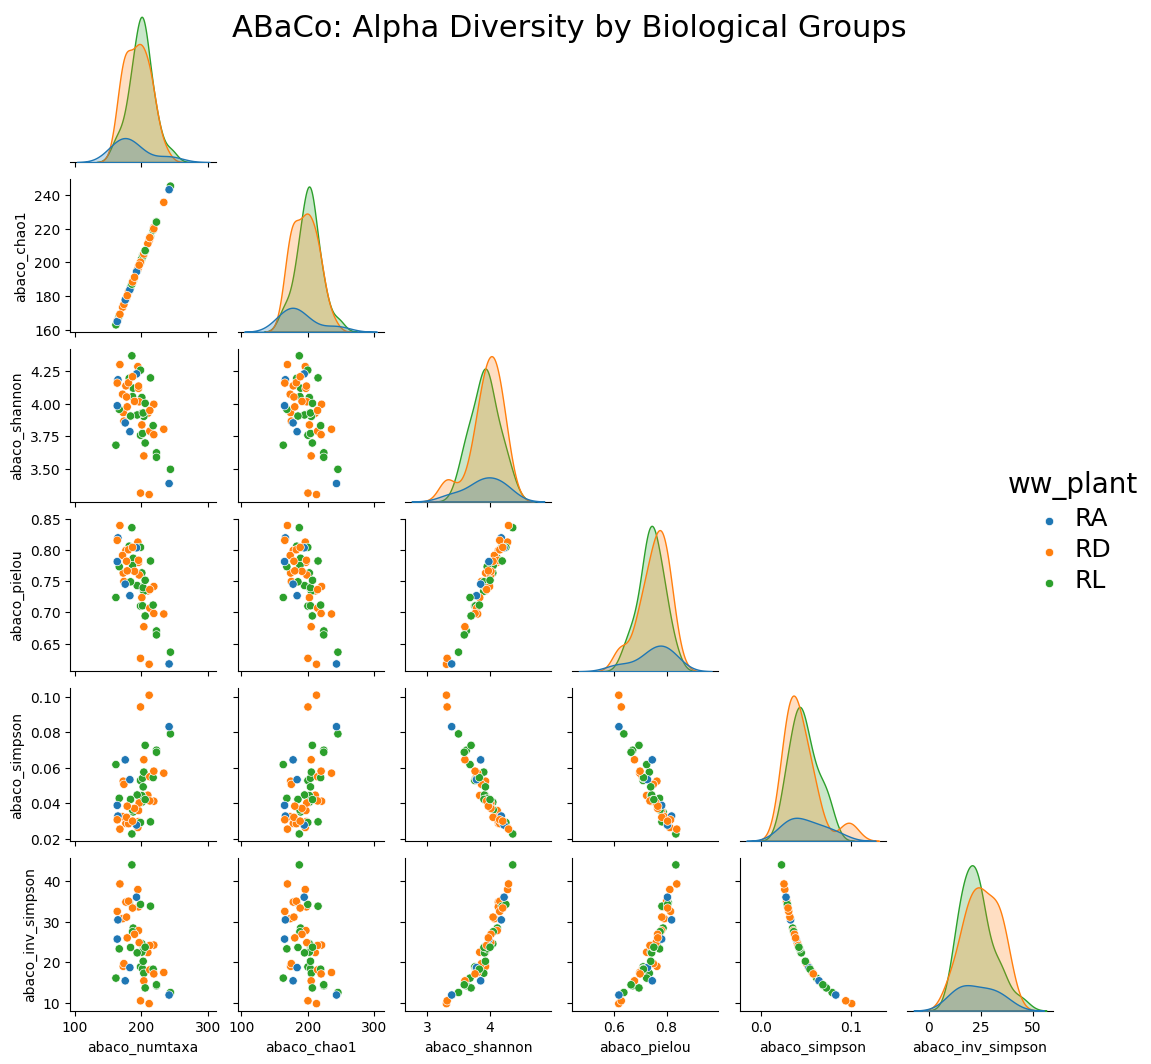

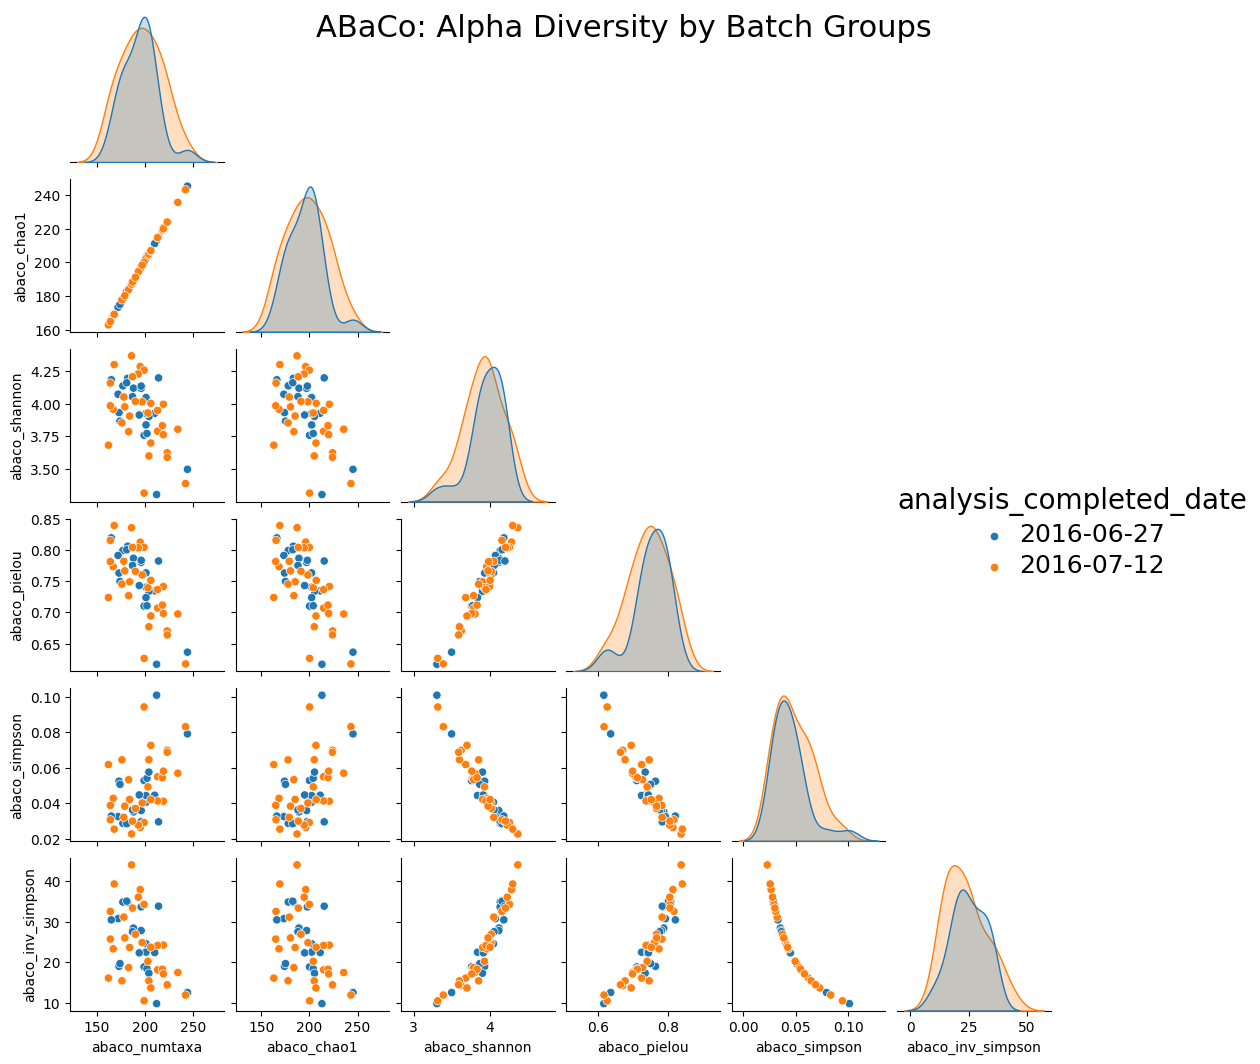

In [13]:
## PREPROCESSING THE ABaCo DATA
# normalize abaco corrected data
adata.layers['normalized_abaco'] = (adata.layers['abaco']/adata.layers['abaco'].sum(axis=1).reshape(-1,1))
# CLR transform normalized ABaCo data
adata.layers['clr_abaco'] = clr(np.where(adata.layers['normalized_abaco'] > 0, adata.layers['normalized_abaco'], 1e-10))

## Alpha diversity metrics on ABaCo corrected data
# Diversity: Number of unique taxa per sample as new metadata
adata.obs['abaco_numtaxa'] = (adata.layers['abaco'] > 0).sum(axis=1) 
# Diversity with correction: Chao1 estimator
# Chao1 = num observed taxa + (num singletons / (2 x num doubletons))
num_singletons = (adata.layers['abaco'] == 1).sum(axis=1)
num_doubletons = (adata.layers['abaco'] == 2).sum(axis=1)
adata.obs['abaco_chao1'] = (adata.layers['abaco'] > 0).sum(axis=1) + (num_singletons / (2 * num_doubletons))
# Diversity: Shannon index H = -sum(p_i * log(p_i)), entropy
adata.obs['abaco_shannon'] = entropy(adata.layers['normalized_abaco'], nan_policy='omit', axis=1)
# Evenness: Pielou evenness index P = H/H_max, H_max = ln(num species)
adata.obs['abaco_pielou'] = adata.obs['abaco_shannon'] / np.log(adata.obs['abaco_numtaxa'])
# Diversity: simpson index lambda = sum(p_i ^2)
adata.obs['abaco_simpson'] = (adata.layers['normalized_abaco'] ** 2).sum(axis=1)
# Diversity: inverse simpson index D = 1/lambda
adata.obs['abaco_inv_simpson'] = 1 / adata.obs['abaco_simpson']

## PAIRPLOTS OF ALPHA DIVERSITY METRICS
# prep df for vis
df_abaco_alphas = adata.obs[[
    'abaco_numtaxa', 'abaco_chao1', 'abaco_shannon', 
    'abaco_pielou', 'abaco_simpson', 'abaco_inv_simpson',
    batch_col, bio_col
]].copy()
# plotting by bio groups
g1 = sns.pairplot(df_abaco_alphas, hue=bio_col, corner=True, height=1.8)
g1.figure.suptitle('ABaCo: Alpha Diversity by Biological Groups', fontsize=22)
plt.setp(g1._legend.get_texts(), fontsize=18)
plt.setp(g1._legend.get_title(), fontsize=20)
g2 = sns.pairplot(df_abaco_alphas, hue=batch_col, corner=True, height=1.8)
g2.figure.suptitle('ABaCo: Alpha Diversity by Batch Groups', fontsize=22)
plt.setp(g2._legend.get_texts(), fontsize=18)
plt.setp(g2._legend.get_title(), fontsize=20)

### Conclusion

The goal was to: 

&#x2705; correct the batch effect (reduce clustering of points by colour in the PCoA and pairplot coloured by batches)

&#x2705; maintain biological variance (maintain pattern of shapes in PCoA and maintain pairplot coloured by wwtp location)

A brief visual inspection of the PCoA and alpha diversity of the reconstructed data suggests that ABaCo reduced the batch effect associated with analyzing the samples on different dates, while still retaining any variance due to the condition of wwtp location.


---